In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Game

In [2]:
import numpy as np
import matplotlib.pyplot as plt

ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

base_dir = '/content/drive/MyDrive/Projects/DRL/Final_Run'

class Game():
    """ 2048 game environment"""
    def __init__(self, size = 4, seed = 42, negative_reward = -10, reward_mode='log2', cell_move_penalty = 0.1):
        self.board_dim = size               # board dimension
        self.state_size = size * size       # total number of cells
        self.action_size = 4                # number of available actions
        np.random.seed(seed)
        self.best_game_history = []
        self.negative_reward = negative_reward
        self.reward_mode = reward_mode
        self.cell_move_penalty = cell_move_penalty
        
    def reset(self, init_fields = 2, step_penalty = 0):
        """ Initializes the board
        Params
        ======
            init_fields (int): how many fields to fill initially
            step_penalty (int): the cost of an action
        """
        self.game_board = np.zeros((self.board_dim, self.board_dim))
        
        for i in range(init_fields):
            self.fill_random_empty_cell()
            
        self.score = np.sum(self.game_board)
        self.reward = 0
        self.current_cell_move_penalty = 0
        self.done = False
        self.steps = 0
        self.rewards_list = []
        self.scores_list = []
        self.step_penalty = step_penalty
        self.history = []
        
        self.history.append({
            'action': -1,
            'new_board': self.game_board.copy(),  
            'old_board': None,
            'score': self.score,
            'reward': self.reward
        })
        
    def shift(self, board):
        """ Shifts all cells to the left and gathers penalties if needed """
        shifted_board = np.empty((board.shape[0], board.shape[1]))
        for i, row in enumerate(board):
            shifted = np.zeros(len(row))
            idx = 0
            for iv, v in enumerate(row):
                if v != 0:
                    shifted[idx] = v
                    if iv != idx:
                        self.current_cell_move_penalty += self.cell_move_penalty * v
                    idx += 1
            shifted_board[i] = shifted
        return shifted_board
        
    def calc_board(self, board):
        """ Calculate all cell mergers and return the new state of the board"""
        
        self.reward = 0
        self.current_cell_move_penalty = 0
        
        shifted_board = self.shift(board)
        
        merged_board = np.empty((shifted_board.shape[0], shifted_board.shape[1]))
        for idx, row in enumerate(shifted_board):
            for i in range(len(row)-1):
                if row[i] != 0 and row[i] == row[i+1]:
                    
                    row[i] = row[i] * 2
                    row[i+1] = 0
                    if self.reward_mode == 'log2':
                        self.reward += np.log2(row[i])
                    else:
                        self.reward += row[i]

            merged_board[idx] = row
        merged_board = self.shift(merged_board)
        
        return merged_board

    def current_state(self):
        """ Returns a flattened array of board cell values """
        return np.reshape(self.game_board.copy(), -1)
    
    def step(self, action, action_values):
        """ Applies the selected action to the board """
        old_board = self.game_board.copy()
        temp_board = self.game_board.copy()
        
        # Here we flip/transpose the board depending on the action in order to unify the calculation
        if action == ACTION_LEFT:
            temp_board = self.calc_board(temp_board)

        elif action == ACTION_RIGHT:
            temp_board = np.flip(self.calc_board(np.flip(temp_board, axis=1)), axis=1)

        elif action == ACTION_UP:
            temp_board = np.transpose(
                np.flip(
                    self.calc_board(np.flip(np.transpose(temp_board), axis=0)), axis=0))

        elif action == ACTION_DOWN:
            temp_board = np.transpose(
                np.flip(
                    self.calc_board(np.flip(np.transpose(temp_board), axis=1)), axis=1))
        else: # just in case it happens
            return (self.game_board, 0, self.done)
        
        if not np.array_equal(self.game_board, temp_board):
            # Fill an empty cell with a new value
            self.game_board = temp_board.copy()
            self.fill_random_empty_cell()

            # Reward is the sum of the merged cells minus step cost
            self.reward = self.reward - self.current_cell_move_penalty
            
            self.score = np.sum(self.game_board)
            self.done = self.check_is_done()
            self.moved = True
        else:
            self.reward = self.negative_reward
            self.moved = False
        self.steps += 1
        self.rewards_list.append(self.reward)
        
        # Save the new state
        self.history.append({
            'action': action,
            'action_values': action_values,
            'old_board': old_board,
            'new_board': self.game_board.copy(),  
            'score': self.score,
            'reward': self.reward
        })

        return (self.game_board, self.reward, self.done)
    
    def check_is_done(self, board = None):
        """ Check if the game is over """
    
        if board is None:
            board = self.game_board
    
        # If there are at least one cell with 0, then the game is not over
        if not np.all(board):
            return False
        
        # If all cells are filled, we need to check if there are any possible moves
        else:
            # Check if there are any equal adjacent cells across horisontal and vertical axes
            for row in board:
                for cell in range(len(row) - 1):
                    if row[cell] == row[cell+1]:
                        return False
            
            for row in np.transpose(board):
                for cell in range(len(row) - 1):
                    if row[cell] == row[cell+1]:
                        return False
            
            # There are no equal adjacent cells, the game is over
            return True
    
    def fill_random_empty_cell(self, playing=True):
        """ Finds an empty cell and fills it with 2 or 4 with 90/10% probability respectively (as per game rules on Wikipedia) """
        
        # If all cells are filled, there is no place to put a new value, just pass
        if np.all(self.game_board):
            return
        
        # Pick the cell
        x = np.random.randint(self.board_dim)
        y = np.random.randint(self.board_dim)
        
        # Check if it is empty, otherwise pick a new one
        while self.game_board[x, y] != 0:
            x = np.random.randint(self.board_dim)
            y = np.random.randint(self.board_dim)
        
        # If it is a regular game, only values 2 and 4 are allowed
        self.game_board[x, y] = np.random.choice([2, 4], p=[0.9, 0.1])
        
    def draw_board(self, board = None, title = 'Current game'):
        """ Draws a colored game board """
        cell_colors = {
            0: '#FFFFFF',
            2: '#EEE4DA',
            4: '#ECE0C8',
            8: '#ECB280',
            16:'#EC8D53',
            32:'#F57C5F',
            64:'#E95937',
            128:'#F3D96B',
            256:'#F2D04A',
            512:'#E5BF2E',
            1024:'#E2B814',
            2048:'#EBC502',
            4096:'#00A2D8',
            8192:'#9ED682',
            16384:'#9ED682',
            32768:'#9ED682',
            65536:'#9ED682',
            131072:'#9ED682',
        }

        if board is None:
            board = self.game_board
        
        ncols = self.board_dim
        nrows = self.board_dim

        # create the plots
        fig = plt.figure(figsize=(3,3))
        plt.suptitle(title)
        axes = [ fig.add_subplot(nrows, ncols, r * ncols + c) for r in range(0, nrows) for c in range(1, ncols+1) ]

        # add some data
        v = np.reshape(board, -1)
        for i, ax in enumerate(axes):
            ax.text(0.5, 0.5, str(int(v[i])), horizontalalignment='center', verticalalignment='center')
            ax.set_facecolor(cell_colors[int(v[i])])

        # remove the x and y ticks
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show()

## Network

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64, fc3_units = 64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.bn3 = nn.BatchNorm1d(fc3_units)
        self.act3 = nn.ReLU()

        self.fc_value = nn.Linear(fc3_units, 256)
        self.bnv = nn.BatchNorm1d(256)
        self.actv = nn.ReLU()
        self.fc_adv = nn.Linear(fc3_units, 256)
        self.bna = nn.BatchNorm1d(256)
        self.acta = nn.ReLU()

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.act3(x)

        value = self.fc_value(x)
        value = self.bnv(value)
        value = self.actv(value)
        adv = self.fc_adv(x)
        adv = self.bna(adv)
        adv = self.acta(adv)

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

## Memory

In [4]:
import numpy as np
import random
import pickle
import copy
import time
from collections import namedtuple, deque
import pandas as pd
import torch.optim as optim

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        
        self.episode_memory = []
        self.batch_size = batch_size
        
        self.seed = random.seed(seed)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done", "error", "action_dist", "weight"])
        self.geomspaces = [np.geomspace(1., 0.5, i) for i in range(1, 10)]

    def dump(self):
        # Saves the buffer into dict object
        d = {
            'action_size': self.action_size,
             'batch_size': self.batch_size,
             'seed': self.seed,
             'geomspaces': self.geomspaces
        }

        d['memory'] = [d._asdict() for d in self.memory]
        return d

    def load(self, d):
        # creates a new buffer from dict
        self.action_size = d['action_size']
        self.batch_size = d['batch_size']
        self.seed = d['seed']
        self.geomspaces = d['geomspaces']

        for e in d['memory']:
            self.memory.append(self.experience(**e))

    def reset_episode_memory(self):
        self.episode_memory = []
        
    def add(self, state, action, reward, next_state, done, error, action_dist, weight = None):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done, error, action_dist, weight)
        self.episode_memory.append(e)

    def add_episode_experiences(self):
        self.memory.extend(self.episode_memory)
        self.reset_episode_memory()
        
    def calc_expected_rewards(self, steps_ahead = 1, weight = None):

        rewards = [e.reward for e in self.episode_memory if e is not None]

        exp_rewards = [np.sum(rewards[i:i+steps_ahead] * self.geomspaces[steps_ahead-1]) for i in range(len(rewards) - steps_ahead)]

        temp_memory = []
        
        for i, e in enumerate(self.episode_memory[:-steps_ahead]):
            t_e = self.experience(e.state, e.action, exp_rewards[i], e.next_state, e.done, e.error, e.action_dist, weight)
            temp_memory.append(t_e)

        self.episode_memory = temp_memory
            
    def sample(self, mode='random'):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
            
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Agent

In [6]:
BUFFER_SIZE = 5000    # replay buffer size
BATCH_SIZE = 1024       # minibatch size
GAMMA = 0.99            # discount factor
LR = 0.00005            # learning rate
TAU = 0.001             # for soft update of target parameters

base_dir = '/content/drive/MyDrive/Projects/DRL/Final_Run'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """ Interacts with and learns from the environment """

    def __init__(self, state_size = 4*4, action_size = 4, seed = 42,
                 fc1_units=256, fc2_units=256, fc3_units=256, 
                 buffer_size = BUFFER_SIZE, batch_size = BATCH_SIZE, 
                 lr = LR, use_expected_rewards = True, predict_steps = 2,
                 gamma = GAMMA, tau = TAU):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            fc*_units (int): size of the respective layer
            buffer_size (int): number of steps to save in replay buffer
            batch_size (int): self-explanatory
            lr (float): learning rate
            use_expected_rewards (bool): whether to predict the weighted sum of future rewards or just for current step
            predict_steps (int): for how many steps to predict the expected rewards            
        """
        TAU = tau
        GAMMA = gamma
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        random.seed(seed)
        np.random.seed(seed)
        self.batch_size = batch_size
        self.losses = []
        self.use_expected_rewards = use_expected_rewards
        self.current_iteration = 0
          
        # Game scores
        self.scores_list = []
        self.last_n_scores = deque(maxlen=50)
        self.mean_scores = []
        self.max_score = 0
        self.min_score = 1000
        self.best_score_board = []

        # Rewards
        self.total_rewards_list = []
        self.last_n_total_rewards = deque(maxlen=50)
        self.mean_total_rewards = []
        self.max_total_reward = 0
        self.best_reward_board = []

        # Max cell value on game board
        self.max_vals_list = []
        self.last_n_vals = deque(maxlen=50)
        self.mean_vals = []
        self.max_val = 0
        self.best_val_board = []

        # Number of steps per episode
        self.max_steps_list = []
        self.last_n_steps = deque(maxlen=50)
        self.mean_steps = []
        self.max_steps = 0
        self.total_steps = 0
        self.best_steps_board = []
        
        self.actions_avg_list = []
        self.actions_deque = {
            0:deque(maxlen=50),
            1:deque(maxlen=50),
            2:deque(maxlen=50),
            3:deque(maxlen=50)
        }

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed, fc1_units=fc1_units, fc2_units=fc2_units, fc3_units = fc3_units).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, fc1_units=fc1_units, fc2_units=fc2_units, fc3_units = fc3_units).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)
        lr_s = lambda epoch: 0.998 ** (epoch % 1000) if epoch < 100000 else 0.999 ** (epoch % 1000) 
        self.lr_decay = optim.lr_scheduler.StepLR(self.optimizer, 1000, 0.9999)

        # Replay buffer
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)

        # Initialize time step
        self.t_step = 0
        self.steps_ahead = predict_steps

    def save(self, name):
        """Saves the state of the model and stats
        
        Params
        ======
            name (str): name of the agent version used in dqn function
        """
        
        torch.save(self.qnetwork_local.state_dict(), base_dir+'/network_local_%s.pth' % name)
        torch.save(self.qnetwork_target.state_dict(), base_dir+'/network_target_%s.pth' % name)
        torch.save(self.optimizer.state_dict(), base_dir+'/optimizer_%s.pth' % name)
        torch.save(self.lr_decay.state_dict(), base_dir+'/lr_schd_%s.pth' % name)
        state = {
            'state_size': self.state_size,
            'action_size': self.action_size,
            'seed': self.seed,
            'batch_size': self.batch_size,
            'losses': self.losses,
            'use_expected_rewards': self.use_expected_rewards,
            'current_iteration': self.current_iteration,
        
        # Game scores
            'scores_list': self.scores_list,
            'last_n_scores': self.last_n_scores,
            'mean_scores': self.mean_scores,
            'max_score': self.max_score,
            'min_score': self.min_score,
            'best_score_board': self.best_score_board,

        # Rewards
            'total_rewards_list': self.total_rewards_list,
            'last_n_total_rewards': self.last_n_total_rewards,
            'mean_total_rewards': self.mean_total_rewards,
            'max_total_reward': self.max_total_reward,
            'best_reward_board': self.best_reward_board,

        # Max cell value on game board
            'max_vals_list': self.max_vals_list,
            'last_n_vals': self.last_n_vals,
            'mean_vals': self.mean_vals,
            'max_val': self.max_val,
            'best_val_board': self.best_val_board,

        # Number of steps per episode
            'max_steps_list': self.max_steps_list,
            'last_n_steps': self.last_n_steps,
            'mean_steps': self.mean_steps,
            'max_steps': self.max_steps,
            'total_steps': self.total_steps,
            'best_steps_board': self.best_steps_board,

            'actions_avg_list': self.actions_avg_list,
            'actions_deque': self.actions_deque,
        # Replay buffer
            'memory': self.memory.dump(),
        # Initialize time step
            't_step': self.t_step,
            'steps_ahead': self.steps_ahead
        }

        with open(base_dir+'/agent_state_%s.pkl' % name, 'wb') as f:
            pickle.dump(state, f)

    def load(self, name):
        """Saves the state of the model and stats
        
        Params
        ======
            name (str): name of the agent version used in dqn function
        """
        self.qnetwork_local.load_state_dict(torch.load(base_dir+'/network_local_%s.pth' % name))
        self.qnetwork_target.load_state_dict(torch.load(base_dir+'/network_target_%s.pth' % name))
        self.optimizer.load_state_dict(torch.load(base_dir + '/optimizer_%s.pth' % name))
        self.lr_decay.load_state_dict(torch.load(base_dir + '/lr_schd_%s.pth' % name))
        
        with open(base_dir+'/agent_state_%s.pkl' % name, 'rb') as f:
            state = pickle.load(f)

        self.state_size = state['state_size']
        self.action_size = state['action_size']
        self.seed = state['seed']
        random.seed(self.seed)
        np.random.seed(self.seed)
        self.batch_size = state['batch_size']
        self.losses = state['losses']
        self.use_expected_rewards = state['use_expected_rewards']
        self.current_iteration = state['current_iteration']
        
        # Game scores
        self.scores_list = state['scores_list']
        self.last_n_scores = state['last_n_scores']
        self.mean_scores = state['mean_scores']
        self.max_score = state['max_score']
        self.min_score = state['min_score'] if 'min_score' in state.keys() else state['max_score']
        self.best_score_board = state['best_score_board']

        # Rewards
        self.total_rewards_list = state['total_rewards_list']
        self.last_n_total_rewards = state['last_n_total_rewards']
        self.mean_total_rewards = state['mean_total_rewards']
        self.max_total_reward = state['max_total_reward']
        self.best_reward_board = state['best_reward_board']

        # Max cell value on game board
        self.max_vals_list = state['max_vals_list']
        self.last_n_vals = state['last_n_vals']
        self.mean_vals = state['mean_vals']
        self.max_val = state['max_val']
        self.best_val_board = state['best_val_board']

        # Number of steps per episode
        self.max_steps_list = state['max_steps_list']
        self.last_n_steps = state['last_n_steps']
        self.mean_steps = state['mean_steps']
        self.max_steps = state['max_steps']
        self.total_steps = state['total_steps']
        self.best_steps_board = state['best_steps_board']
        
        self.actions_avg_list = state['actions_avg_list']
        self.actions_deque = state['actions_deque']

        # Replay buffer
        self.memory.load(state['memory'])
        
        # Initialize time step
        self.t_step = state['t_step']
        self.steps_ahead = state['steps_ahead']

        
    def step(self, state, action, reward, next_state, done, error, action_dist):
        # Save experience in replay memory    
        self.memory.add(state, action, reward, next_state, done, error, action_dist, None)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        return action_values.cpu().data.numpy()
        
    def learn(self, learn_iterations, mode = 'board_max', save_loss = True, gamma = GAMMA, weight = None):
        
        if self.use_expected_rewards:
            self.memory.calc_expected_rewards(self.steps_ahead, weight)
            
        self.memory.add_episode_experiences()
        
        losses = []
        
        if len(self.memory) > self.batch_size:
            if learn_iterations is None:
                learn_iterations = self.learn_iterations
        
            for i in range(learn_iterations):

                states, actions, rewards, next_states, dones = self.memory.sample(mode=mode)
                
                q_eval = self.qnetwork_local(states).gather(1, actions)
                q_next = self.qnetwork_target(next_states).detach()
                q_target = rewards + GAMMA * q_next.max(1)[0].view(self.batch_size, 1)
                
                # Compute loss
                loss = F.mse_loss(q_eval, q_target)
                # Store loss
                losses.append(loss.detach().numpy())

                # Minimize the loss
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            self.lr_decay.step()
            
            if save_loss:
                self.losses.append(np.mean(losses))
        else:
            self.losses.append(0)
                
    def soft_update(self, local_model, target_model, tau):
        """
                Soft update model parameters.
                θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Preprocess State

In [7]:
def transform_state(state, mode='plain'):
    
    if mode == 'plain':
        return np.reshape(state, -1)
    
    elif mode == 'log2':
        state = np.reshape(state, -1)
        state[state == 0] = 1
        return np.log2(state) / 17
    
    elif mode == 'one_hot':
        state = np.reshape(state, -1)
        state[state == 0] = 1
        state = np.log2(state)
        state = state.astype(int)
        new_state = np.reshape(np.eye(18)[state], -1)     
        return new_state

    else:
        return state

## Dueling DQN

In [8]:
def dqn(n_episodes=100, eps_start=0.05, eps_end=0.001, eps_decay=0.995, step_penalty = 0, sample_mode = 'error',
        start_learn_iterations = 20,testing=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        step_penalty (int): if we want to deduct some points from the reward for taking a step, put it here
        sample_mode (str): how to assign sample probabilities for experiences in the replay buffer
        learn_iterations (int): number of learning iterations after each episode
    """
    
    eps = eps_start
    starting_iteration = agent.current_iteration
    best_game_history, worst_game_history = load_game_history(version)
    learn_iterations = start_learn_iterations
    
    # main loop
    for i_episode in range(1, n_episodes+1):
        print('episode ',i_episode)
        agent.current_iteration = agent.current_iteration + 1
        time_start = time.time()
        
        # keep track of different actions taken per episode
        actions = np.array([0, 0, 0, 0])
        
        # Starting with a fresh board
        env.reset(2, step_penalty)                        # reset environment
        
        if testing:
            print(env.game_board)
            print("=================")
        
        state = transform_state(env.current_state(), mode = 'one_hot')   # get the current state        
        reward = env.reward                               # get the reward
        total_rewards = reward                            # initialize total rewards
        score = env.score                                 # initialize the score
        agent.total_steps = 0
        
        # keep playing
        while not env.done:
            reward = env.negative_reward
            
            action_values = agent.act(state)    # select an action
            
            actions_sorted = [(i, v) for i, v in enumerate(action_values[0])]
            actions_sorted = sorted(actions_sorted, key=lambda x: x[1], reverse=True)
            
            random_action = random.choice(np.arange(agent.action_size))
            action_idx = 0
            env.moved = False
            while not env.moved:
                
                if random.random() < eps:
                    action_elem = actions_sorted[random_action]
                else:
                    action_elem = actions_sorted[action_idx]
                    action_idx += 1

                action = np.int64(action_elem[0])
                actions[action] += 1
                env.step(action, action_values)                                # send the action to environment
                
                if testing:
                    print(env.game_board)
                    print("=================")
        
                next_state = transform_state(env.current_state(), mode = 'one_hot')   # get the current state        
                reward = env.reward                             # get the reward

                # save the results of the step
                error = np.abs(reward - action_elem[1]) ** 2
                score = env.score
                done = env.done                             # check if episode has finished

                # learning step
                if len(agent.actions_avg_list) > 0:
                    actions_dist = [np.mean(agent.actions_deque[i]) for i in range(4)][action]
                else:
                    actions_dist = (actions / np.sum(actions))[action]

                # Save this experience
                agent.step(state, action, reward, next_state, done, error, actions_dist) 

                state = next_state

                agent.total_steps += 1
                total_rewards += reward

                if done:
                    break 
        
        # Do the actual learning
        agent.learn(learn_iterations, mode=sample_mode, save_loss = True, weight = env.game_board.max())
        
        # Calculate action stats
        actions = actions / env.steps
        
        agent.actions_deque[0].append(actions[0])
        agent.actions_deque[1].append(actions[1])
        agent.actions_deque[2].append(actions[2])
        agent.actions_deque[3].append(actions[3])
        
        agent.actions_avg_list.append([np.mean(agent.actions_deque[i]) for i in range(4)])
        
        # Here we keep track of the learning progress and save the best values
        if total_rewards > agent.max_total_reward:
            agent.max_total_reward = total_rewards
        
        if score > agent.max_score:
            agent.max_score = score
            agent.best_score_board = env.game_board.copy()
            best_game_history = env.history.copy()
        
        if score < agent.min_score:
            agent.min_score = score
            worst_game_history = env.history.copy()
        
        if env.game_board.max() > agent.max_val:
            agent.max_val = env.game_board.max()
            agent.best_val_board = env.game_board.copy()
        
        if env.steps > agent.max_steps:
            agent.max_steps = env.steps
            agent.best_steps_board = env.game_board.copy()
            
        
        agent.total_rewards_list.append(total_rewards)
        agent.scores_list.append(score)                 # save most recent score to total
        agent.max_vals_list.append(env.game_board.max())
        agent.max_steps_list.append(env.steps)
        
        agent.last_n_scores.append(score)
        agent.last_n_steps.append(env.steps)
        agent.last_n_vals.append(env.game_board.max())
        agent.last_n_total_rewards.append(total_rewards)
        
        agent.mean_scores.append(np.mean(agent.last_n_scores))
        agent.mean_steps.append(np.mean(agent.last_n_steps))
        agent.mean_vals.append(np.mean(agent.last_n_vals))
        agent.mean_total_rewards.append(np.mean(agent.last_n_total_rewards))
        
        time_end = time.time()
        
        # Increasing the epsilon every N episodes in order to allow for some exploration 
        if agent.current_iteration % 5000 == 0:
            eps = eps * 2
        else:
            eps = max(eps_end, eps_decay*eps)    # decrease epsilon
            
        # Update Network Parameters
        if agent.total_steps % 100 == 0:
            agent.soft_update(agent.qnetwork_local,agent.qnetwork_target,TAU)
        
        # Display training stats 
        if agent.current_iteration % 100 == 0:
            clear_output()
            
            # Training metrics
            fig, ax1 = plt.subplots()
            fig.set_size_inches(16,6)
            ax1.plot(agent.max_vals_list + [None for i in range(10000 - len(agent.scores_list))], label='Max cell value seen on board', alpha = 0.3, color='g')
            ax1.plot(agent.mean_steps + [None for i in range(10000 - len(agent.scores_list))], label='Mean steps over last 50 episodes', color='b')
            
            # ax1.plot(agent.scores_list + [None for i in range(10000 - len(agent.scores_list))], label='Scores', color='c', alpha=0.2)            
            # ax1.plot(agent.mean_scores + [None for i in range(10000 - len(agent.scores_list))], label='Mean score over last 50 episodes', color='y')

            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            
            ax2.plot(agent.mean_total_rewards + [None for i in range(10000 - len(agent.scores_list))], label='Mean total rewards over last 50 episodes', color='r')            
            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.xlabel('Episode #')
            handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
            plt.legend(handles, labels)
            plt.savefig('/content/drive/MyDrive/Projects/DRL/Final_Run/'+version+'_episode.png')
            plt.show()
            
            plt.figure(figsize=(16,6))
            plt.title('Loss')
            plt.plot(agent.losses)
            plt.yscale('log')
            plt.savefig('/content/drive/MyDrive/Projects/DRL/Final_Run/'+version+'_loss.png')
            plt.show()
            
            # Averaged actions stats
            plt.figure(figsize=(16,6))
            plt.title('Averaged actions distribution per game')
            a_list = np.array(agent.actions_avg_list).T
            
            plt.stackplot([i for i in range(1, len(agent.actions_avg_list)+1)], a_list[0], a_list[1], a_list[2], a_list[3], labels=['Up %0.2f' % (agent.actions_avg_list[-1][0] * 100), 'Down %0.2f' % (agent.actions_avg_list[-1][1] * 100), 'Left %0.2f' % (agent.actions_avg_list[-1][2] * 100), 'Right %0.2f' % (agent.actions_avg_list[-1][3] * 100)] )
            plt.legend()
            plt.show()               
            
            # Display the board with the best score
            env.draw_board(agent.best_score_board, 'Best score board')
            
            # Save the model and the game history
            save_state(version, eps)
            save_game_history(version, best_game_history, worst_game_history)
            

In [9]:
base_dir = '/content/drive/MyDrive/Projects/DRL/Final_Run' 

def save_state(name, eps):
    with open(base_dir+'/game_%s.pkl' % name, 'wb') as f:
        state = {
            'env': env,
            'last_eps': eps
        }
        pickle.dump(state, f)
    agent.save(name)
    
def load_state(name):
    with open(base_dir+'/game_%s.pkl' % name, 'rb') as f:
        state = pickle.load(f)
        g = state['env']
        eps = state['last_eps']
    a = Agent(state_size=4 * 4 * 18, fc1_units=1024, fc2_units=1024, fc3_units = 1024)
    a.load(name)
    return g, a, eps
    
def save_game_history(name, best_history, worst_history):
    with open(base_dir+'/best_game_history_%s.pkl' % name, 'wb') as f:
        pickle.dump(best_history, f)
    with open(base_dir+'/worst_game_history_%s.pkl' % name, 'wb') as f:
        pickle.dump(worst_history, f)
    
def load_game_history(name):
    best_history = []
    worst_history = []
    if os.path.exists(base_dir+'/best_game_history_%s.pkl' % name):
        with open(base_dir+'/best_game_history_%s.pkl' % name, 'rb') as f:
            best_history = pickle.load(f)
    if os.path.exists(base_dir+'/worst_game_history_%s.pkl' % name):
        with open(base_dir+'/worst_game_history_%s.pkl' % name, 'rb') as f:
            worst_history = pickle.load(f)
    return best_history, worst_history

# Hyperparmeter Tuning

In [ ]:
!pip install optuna &> /dev/null

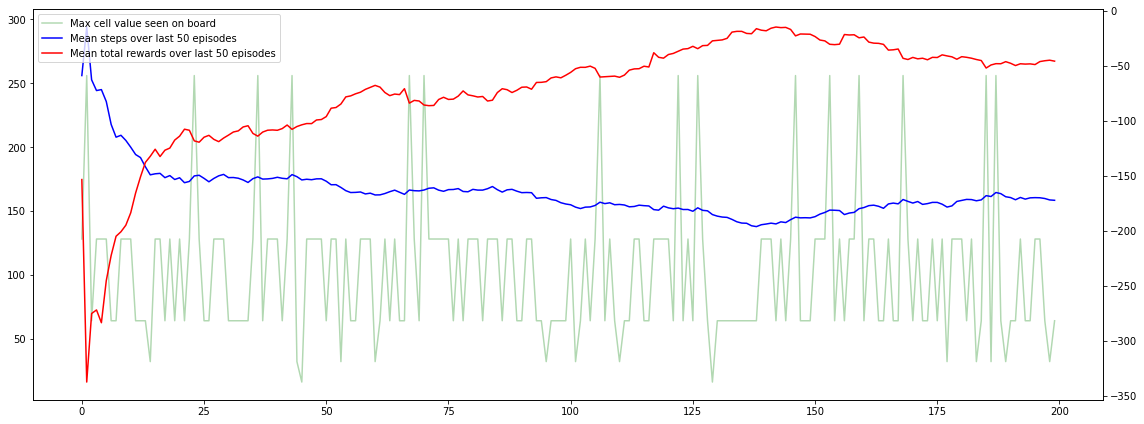

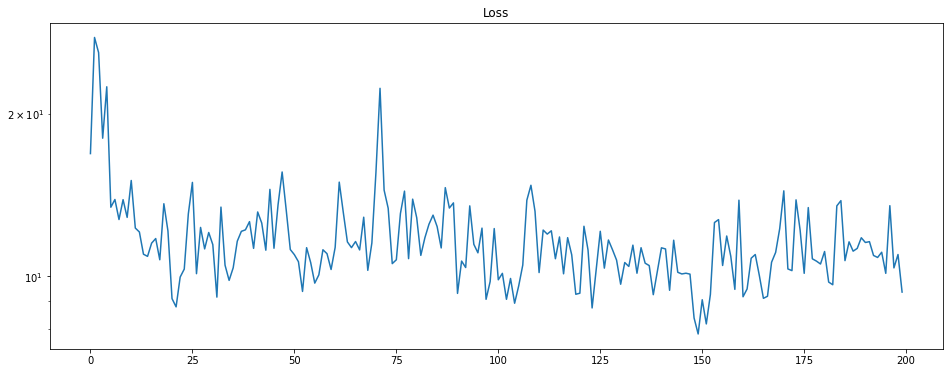

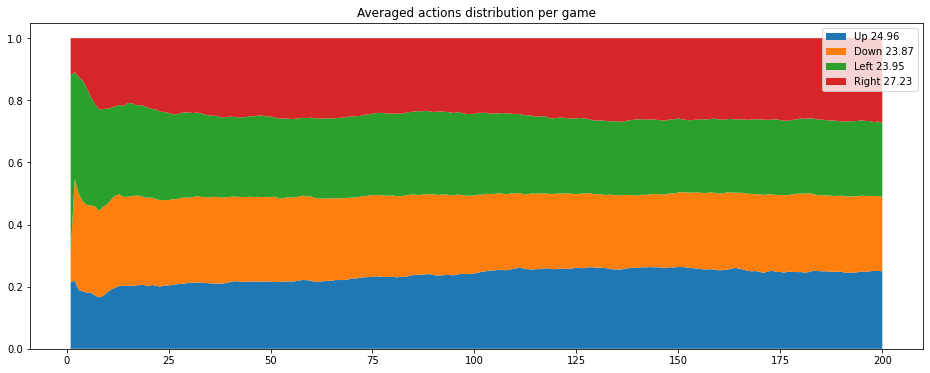

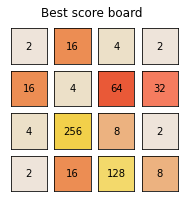

episode  201
episode  202
episode  203
episode  204
episode  205
episode  206
episode  207
episode  208
episode  209
episode  210
episode  211
episode  212
episode  213
episode  214
episode  215
episode  216
episode  217
episode  218
episode  219
episode  220
episode  221
episode  222
episode  223
episode  224
episode  225
episode  226
episode  227
episode  228
episode  229
episode  230
episode  231
episode  232
episode  233
episode  234
episode  235
episode  236
episode  237
episode  238
episode  239
episode  240
episode  241
episode  242
episode  243
episode  244
episode  245
episode  246
episode  247
episode  248
episode  249
episode  250


[I 2022-12-09 15:17:58,140] Trial 11 finished with value: 485.288 and parameters: {'learning_rate': 0.005, 'bufferSize': 100000, 'batchsize': 64}. Best is trial 6 with value: 485.288.


In [ ]:
import optuna

import numpy as np
from collections import deque
import time
import torch
import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import pickle
import os 

version = " "

# Create the environment with 4x4 board
env = Game(4, reward_mode='log2', negative_reward = -2, cell_move_penalty = 0.1)
eps = 0.5

agent = Agent(state_size=env.state_size * 18, action_size=env.action_size,
                seed=42, fc1_units=1024, fc2_units=1024, fc3_units = 1024,
                buffer_size = 70000, batch_size = 1024, lr = 0.004, use_expected_rewards=True, predict_steps = 2,
              gamma = 0.99, tau = 0.001)

def objective(trail):
  global agent,version,eps,env

  learning_rate = trail.suggest_categorical("learning_rate",[0.005,0.0005])
  bufferSize = trail.suggest_categorical("bufferSize",[100000,200000])
  batchsize = trail.suggest_categorical("batchsize",[64,256,1024])

  version = 'lr_'+str(learning_rate)+'_bufferSize_'+str(bufferSize)+'_batchSize_'+str(batchsize)
  print(version)

  # Create the environment with 4x4 board
  env = Game(4, reward_mode='log2', negative_reward = -2, cell_move_penalty = 0.1)
  eps = 0.5
  # Create the agent, duplicating default values for visibility
  agent = Agent(state_size=env.state_size * 18, action_size=env.action_size,
                seed=42, fc1_units=1024, fc2_units=1024, fc3_units = 1024,
                buffer_size = bufferSize, batch_size = batchsize, lr = learning_rate, use_expected_rewards=True, predict_steps = 2,
              gamma = 0.99, tau = 0.001)

  # Run the training
  dqn(n_episodes=250, 
      eps_start=eps, 
      eps_end=0.00001, 
      eps_decay=0.999, 
      step_penalty = 0, 
      sample_mode = 'random',
      start_learn_iterations = 10, 
      bootstrap_iterations = 0, 
      bootstrap_every=50)
  
  return agent.mean_total_rewards[-1]+agent.mean_steps[-1]+agent.mean_vals[-1]+agent.mean_scores[-1]

# study = optuna.create_study(direction="maximize")
# study.optimize(objective,n_trials=16)

search_space = {"batchsize": [64, 256, 1024], "bufferSize": [100000,200000], "learning_rate":[0.005,0.0005]}
study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective)

In [ ]:
trial = study.best_trial

## Optuna helps to visually assess the impact of hyperparameters on the accuracy of the predictions. Let’s visualize the dependence between hyperparameters

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

## Distribution of trials for each hyperparameter

In [ ]:
optuna.visualization.plot_slice(study)

## Hyperparameter importances

In [ ]:
optuna.visualization.plot_param_importances(study)

# Training

## Fresh Training

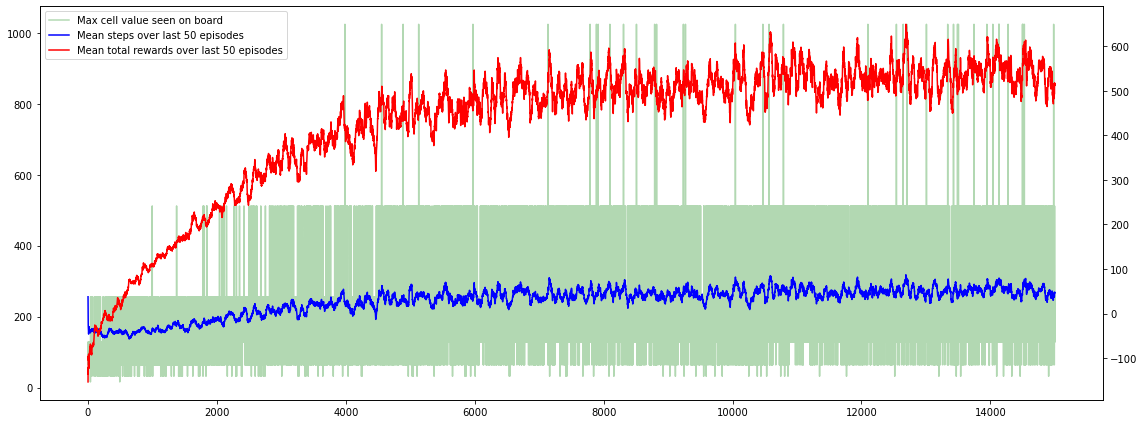

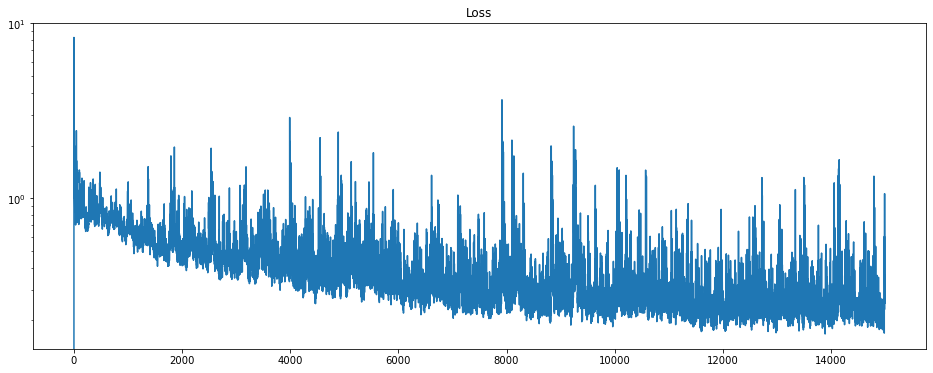

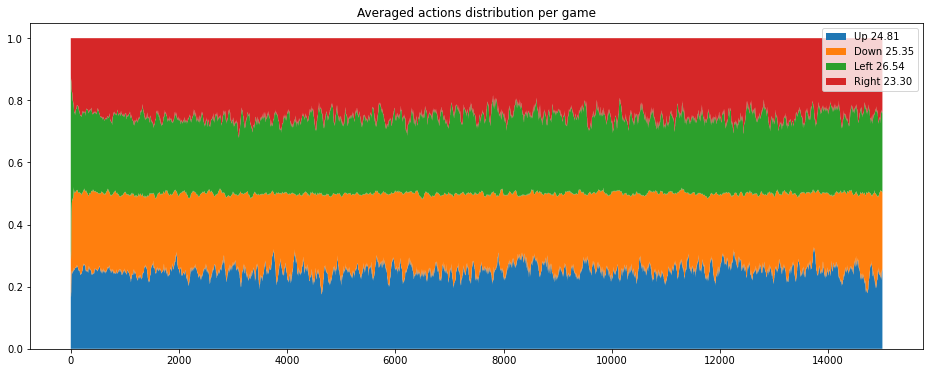

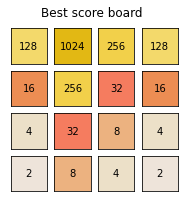

In [ ]:
import numpy as np
from collections import deque
import time
import torch
import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import pickle
import os

version = 'lr_0.0005_batchsize_1024_buffersize_100000_Dueling_DQN'

# Create the environment with 4x4 board
env = Game(4, reward_mode='log2', negative_reward = -2, cell_move_penalty = 0.1)
eps = 0.5
# Create the agent, duplicating default values for visibility
agent = Agent(state_size=env.state_size * 18, action_size=env.action_size,
              seed=42, fc1_units=1024, fc2_units=1024, fc3_units = 1024,
              buffer_size = 100000, batch_size = 1024, lr = 0.0005, use_expected_rewards=True, predict_steps = 2,
             gamma = 0.99, tau = 0.001)

# Run the training
dqn(n_episodes=15000, 
    eps_start=eps or 0.05, 
    eps_end=0.00001, 
    eps_decay=0.999, 
    step_penalty = 0, 
    sample_mode = 'random',
    start_learn_iterations = 10)

## Load Trained Model

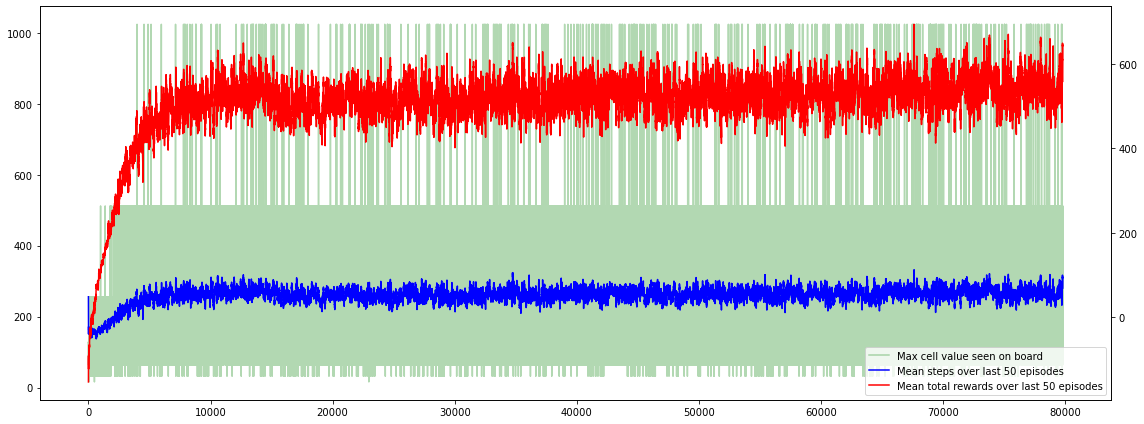

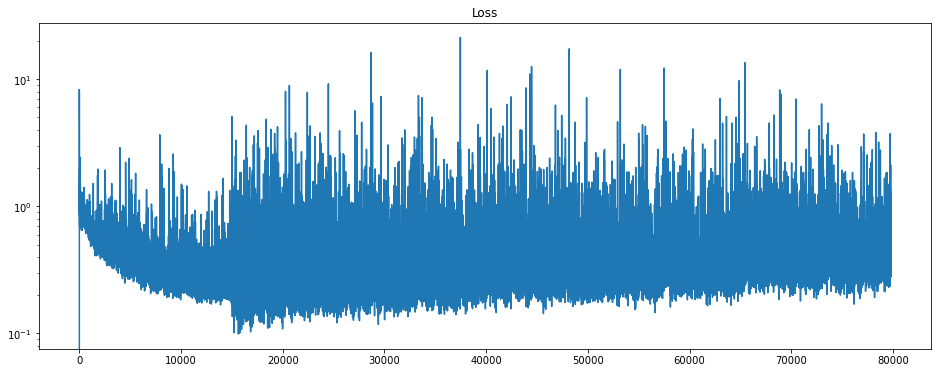

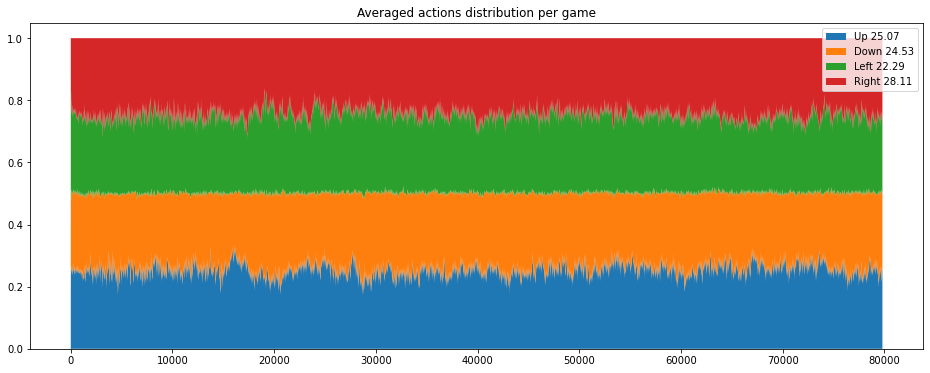

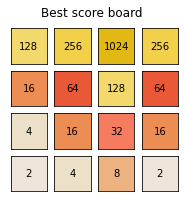

episode  64801
episode  64802
episode  64803
episode  64804
episode  64805
episode  64806
episode  64807
episode  64808
episode  64809
episode  64810
episode  64811
episode  64812
episode  64813
episode  64814
episode  64815
episode  64816
episode  64817
episode  64818
episode  64819
episode  64820
episode  64821
episode  64822
episode  64823
episode  64824
episode  64825
episode  64826
episode  64827
episode  64828
episode  64829


In [ ]:
import numpy as np
from collections import deque
import time
import torch
import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import pickle
import os

version = 'lr_0.0005_batchsize_1024_buffersize_100000_Dueling_DQN'
env, agent, eps = load_state(version)

# Run the training
dqn(n_episodes=65000, 
    eps_start=eps or 0.05, 
    eps_end=0.00001, 
    eps_decay=0.999, 
    step_penalty = 0, 
    sample_mode = 'random',
    start_learn_iterations = 10)

## Training Analysis

In [11]:
import numpy as np
from collections import deque
import time
import torch
import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import pickle
import os

version = 'lr_0.0005_batchsize_1024_buffersize_100000_Dueling_DQN'
env, agent, eps = load_state(version)

arr = np.array(agent.max_vals_list)
from math import log
arr1 = [0]*(11)
for i in range(len(arr)):
    arr1[int(log(arr[i],2)) - 1] += 1
d = {}
for i in range(len(arr1)):
    d[str(2**(i+1))] = round(arr1[i]*100/(len(arr)),2)

df = pd.DataFrame(d, index=[0])
  
print('Episodes Trained : ',len(agent.max_vals_list))    

print('Results : ')
df

Episodes Trained :  79800
Results : 


,2,4,8,16,32,64,128,256,512,1024,2048
0,0.0,0.0,0.0,0.0,0.54,8.31,33.8,42.29,14.61,0.44,0.0


## Testing Trained Agent

In [ ]:
import numpy as np
from collections import deque
import time
import torch
import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import pickle
import os
    
version = 'lr_0.0005_batchsize_1024_buffersize_100000_Dueling_DQN'
env, agent, eps = load_state(version)

dqn(n_episodes=5, 
    eps_start= eps, 
    eps_end=0.00001, 
    eps_decay=0.999, 
    step_penalty = 0, 
    sample_mode = 'random',
    start_learn_iterations = 10,testing=True)

Streaming output truncated to the last 5000 lines.
[[  2.  16.   0.   0.]
 [128.  32.   2.   2.]
 [ 32.  64.  16.   0.]
 [ 16.   8.   4.   0.]]
[[  2.  16.   2.   0.]
 [128.  32.   4.   0.]
 [ 32.  64.  16.   0.]
 [ 16.   8.   4.   0.]]
[[  2.  16.   2.   0.]
 [128.  32.   4.   0.]
 [ 32.  64.  16.   0.]
 [ 16.   8.   4.   0.]]
[[  2.  16.   2.   0.]
 [128.  32.   4.   0.]
 [ 32.  64.  16.   0.]
 [ 16.   8.   4.   0.]]
[[  2.  16.   2.   0.]
 [128.  32.   4.   0.]
 [ 32.  64.  16.   0.]
 [ 16.   8.   4.   0.]]
[[  2.   2.  16.   2.]
 [  0. 128.  32.   4.]
 [  0.  32.  64.  16.]
 [  0.  16.   8.   4.]]
[[  0.   4.  16.   2.]
 [  4. 128.  32.   4.]
 [  0.  32.  64.  16.]
 [  0.  16.   8.   4.]]
[[  0.   4.  16.   2.]
 [  2. 128.  32.   4.]
 [  0.  32.  64.  16.]
 [  4.  16.   8.   4.]]
[[  2.   4.  16.   2.]
 [  0. 128.  32.   4.]
 [  2.  32.  64.  16.]
 [  4.  16.   8.   4.]]
[[  4.   4.  16.   2.]
 [  4. 128.  32.   4.]
 [  2.  32.  64.  16.]
 [  0.  16.   8.   4.]]
[[  0.   8.  16.   

## Best Game Rendering

In [ ]:
import pickle 
import matplotlib.pyplot as plt 
%matplotlib inline 
from matplotlib.animation import FuncAnimation 
import numpy as np 
 
version = 'lr_0.0005_batchsize_1024_buffersize_100000_Dueling_DQN' 
 
with open('best_game_history_%s.pkl' %version, 'rb') as f: 
    game_history = pickle.load(f) 
   
game = Game(4) 
print(len(game_history)) 
 
game_history = game_history[len(game_history)-30:len(game_history)] 
 
def action_label(a): 
    a_dict = {-1: '-', 0: '^', 1: 'V', 2: '<', 3: '>'} 
    return a_dict[a] 
 
cell_colors = { 
    0: '#FFFFFF', 
    2: '#EEE4DA', 
    4: '#ECE0C8', 
    8: '#ECB280', 
    16:'#EC8D53', 
    32:'#F57C5F', 
    64:'#E95937', 
    128:'#F3D96B', 
    256:'#F2D04A', 
    512:'#E5BF2E', 
    1024:'#E2B814', 
    2048:'#EBC502', 
    4096:'#00A2D8', 
    8192:'#9ED682', 
    16384:'#9ED682', 
    32768:'#9ED682', 
    65536:'#9ED682', 
    131072:'#9ED682', 
} 
 
board = game_history[0]['new_board'] 
 
ncols = 4 
nrows = 4 
 
# create the plots 
fig = plt.figure(figsize=(3,3)) 
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c) for r in range(0, nrows) for c in range(1, ncols+1) ] 
 
def update(i): 
    board = game_history[i]['new_board'] 
    v = np.reshape(board, -1) 
    for i, ax in enumerate(axes): 
        ax.cla() 
        ax.text(0.5, 0.5, str(int(v[i])) if int(v[i]) > 0 else ' ', horizontalalignment='center', verticalalignment='center') 
        ax.set_facecolor(cell_colors[int(v[i])]) 
         
    for ax in axes: 
        ax.set_xticks([]) 
        ax.set_yticks([]) 
 
    return axes 
 
anim = FuncAnimation(fig, update, frames=np.arange(1, len(game_history)), interval=1000) 
 
anim.save('/content/drive/MyDrive/Projects/DRL/Final_Run/2048_short.gif', dpi=160, writer='imagemagick')